# Proton Conducting Electrolyzer Model Development

I will develop the initial model and governing equations for a Proton Conducting Electrolysis cell. 
I will be considering $BaZr_0.8Y_0.2O_{3-\delta}$ (BZY20) as electrolyte, Ni/BZY20 cathode and $Pr_2NiO_{4+\delta}$ (PNO) as anode. Reactions at the electrodes:
\begin{equation}
    H_2O \rightarrow 2H^+ + \frac{1}{2}O_2+2e^-
\end{equation}
\begin{equation}
    2H^+ + 2e^- \rightarrow H_2
\end{equation}

The model domain includes:
- Thin film anode PNO
- Electrolyte BZY20
- Porous Ni/BZY20 cathode


The simulation will assume a constant temperature of 600C. 

Cathode (Ni/BZY20): 5% $H_2$, 95% Ar to avoid the oxidation
Anode (PNO): 30% Steam, 21% $O_2$, and 71% $N_2$. 

Biasing will be done with reference to cathode and 1.5V will be applied.


### State Variables:
##### Cathode:

As all the materials are mixed ionic and electronic conductors, proton and oxygen ion concentrations are considered at each electrode. Charge transfer reactions for both the ions at anode and cathode are modeled.

- hydrogen concentration on the Ni/BZY
- proton surface site concentration on the Ni/BZY
- steam concentration on the Ni/BZY 
- oxygen ion concentration on the electrolyte 
- proton concentration on the electrolyte
- oxygen vacancy site concentration on the electrolyte surface 
- electric potential between the cathode and the electrolyte

##### Electrolyte

- proton concentration in the electrolyte
- oxygen ion concentration in the electrolyte
- electric potential in the electrolyte

##### Anode

- proton concentration on the anode surface 
- oxygen ion concentration 
- steam concentration on the anode surface
- oxygen concentration on the anode surface 
- electric potential between the anode and the electrolyte


## Charge transfer equations:

External current is supplied and it must be equal to the Faradaic current and double layer current. To calculate the double layer current, I am using the mass action kinetics:

$i_{M-A} = nF\left(k_{fwd}\prod_mC_{ac,k}^{\nu_k^\prime}-k_{rev}\prod_mC_{ac,k}^{\nu_k\prime\prime} \right)$

Substituting for $k_{fwd}$ and $k_{rev}$,

$i_{M-A} = nF\left[k^*_{fwd}\exp\left( \frac{-\beta n_{elec}F\Delta\phi}{RT}\right)\prod_mC_{ac,k}^{\nu_k^\prime} -k^*_{rev}\exp\left( \frac{(1-\beta )n_{elec}F\Delta\phi}{RT}\right)\prod_mC_{ac,k}^{\nu_k\prime\prime} \right]$


$\Delta\phi$ is calculated using $\Delta\phi=\frac{-i_{dl}}{C_{dl}}$ and $i_{dl}=i_{ext}-i_{far}$



#### Reactions at each electrode:
###### Anode:
 
Proton:

 $   {\rm H_2O}_{\rm PNO(s)} + []_{\rm PNO(s)} \longrightarrow {\rm 2H}^+_{\rm PNO(s)} + {\rm 2e}^-_{\rm PNO(s)} + {\rm O}_{\rm PNO(s)}  $
 
Oxygen ion:

 $   {\rm O}^-2_{\rm PNO(s)}  \longrightarrow {\rm O}_{\rm PNO(s)} + {\rm 2e}^-_{\rm PNO(s)} $
 
###### Cathode:
 
Proton:

$   {\rm H}_{\rm elyte(s)} + []_{\rm Ni/BZY(s)} +e^-_{\rm Ni/BZY(s)}  \longrightarrow {\rm H}^+_{\rm Ni/BZY(s)} + []_{\rm elyte(s)}   $

Oxgen ion:

 $   {\rm H_2O}_{\rm Ni/BZY(s)} + []_{\rm Ni/BZY(s)} + 2e^-_{\rm Ni/BZY(s)} + []_{\rm elyte(s)}\longrightarrow {\rm 2H}_{\rm Ni/BZY(s)}  + {\rm O}^{2-}_{\rm elyte(s)}  $

### Solution vector:

$$ SV=\begin{bmatrix} \phi_{\rm PNO} \\C_{\rm H^+,s,PNO}\\ C_{\rm O^{2-},s,PNO}\\C_{\rm H_2O,s,PNO}\\ C_{\rm O,s,PNO}\\C_{\rm VA,s,PNO}\\C_{\rm VA,s,elyte}\\\phi_{\rm ca}\\
C_{\rm H^+,s,Ni}\\C_{\rm O^{2-},s,Ni}\\C_{\rm H_2O,s,Ni}
\end{bmatrix}$$

In [31]:

#Initilize variables for the PCEC model

import numpy as np

"Parameters to run the residual function"
i_ext = 30 #A
C_dl_an = 3.67e6 # F/m2 from W.Li et.al. J. materials  Chemistry A (2018)
#C_dl_ca = (-1/w/Im(Z)) from EIS plot
C_dl_ca = 3.33e-3 # F/m2 (need to look up)
t_final = 1000 #seconds

dy_elyte = 1e-3 #electrolyte thickness (1mm)
dy_PNO = 3e-7 #thin film (300nm)
dy_NiBZY = 3e-5# porous cathode (30um)

"Material Parameters"
#BZY20 parameters:
sigma_elyte = 0.001 #1/(ohm*m) 
C_elyte = 22050    # Total (reference) elyte concentration, mol/m2 
D_k = np.array([7.46*10**-11,1.28*10**-12,0]) #(m^2/s) [Proton,Oxygen,Vacancy] 
#PNO parameters:
C_PNO = 1.6e-05 #Surface site Concentrations mol/m^2 
#Ni/BZY parameters:
C_NiBZY = 22000 #mol/m^2 surface site concentration


"The cathode is the reference"
phi_PNO_0 = 1.5
phi_elyte_0 = 0.5 
phi_ca_0 = 0 

dphi_PNO_0 = phi_elyte_0-phi_PNO_0 
dphi_ca_0 = phi_ca_0-phi_elyte_0

"beta values "
beta_an = 0.5 
beta_ca = 0.5

" Constants:"
F = 96485 #C/mol e-
R = 8.314 #J/mol*K
T = 823 #K

"reaction kinetics parameters: (from Hw4) "
#Proton at anode
k_fwd_star_NiBZY_H = 4.16307062e+3 
k_rev_star_NiBZY_H = 4.0650045e+1 
#oxygen at anode
k_fwd_star_NiBZY_O = 4.16307062e+1 
k_rev_star_NiBZY_O = 4.0650045e-1 
#oxygen at cathode
k_fwd_star_PNO_O = 4.16307062e+1 # forward rate constant, m^4/mol^2/s
k_rev_star_PNO_O = 4.0650045e-1 
#proton at cathode
k_fwd_star_PNO_H = 4.16307062e+3 
k_rev_star_PNO_H = 4.0650045e+1 


#rate constants for gas phase 
k_fwd_H2 = 1000
k_rev_H2 = 1

"number of electrons transferred in each reaction"
n_PNO_H = 2
n_PNO_O = 2
n_NiBZY_H = -1
n_NiBZY_O = -2

#Mole fractions 
# Anode:
X_Hx_PNO = 0.05
X_H2O_PNO = 0.05
X_vac_PNO = 0.05
X_O_PNO = 0.05
X_Ox_PNO = 0.8

# Cathode
X_H_NiBZY = 0.6 
X_H2O_NiBZY = 0.2
X_vac_NiBZY = 0.2 
X_Ox_elyte = 0.8 
X_Hx_elyte = 0.1 
X_vac_elyte = 0.1 

# mole fractions for gases as inlet conditions
X_k_an_gas = np.array([0.77, 0.20, 0.03]) #N2, O2 , Steam
X_k_ca_gas = np.array([0.05, 0.95, 0.0]) #H2, Ar, Steam

# pressures
P_an_gas = 101325 # atmospheric pressure
P_ca_gas = 100000 # assumed less than anode side
# concentrations of gases calculated by IGL
C_k_an_gas = X_k_an_gas*((P_an_gas)/(R*T)) 
C_k_ca_gas = X_k_ca_gas*((P_ca_gas)/(R*T)) 

"parameters for gas-phase diffusoin cathode side" #taken from H.Zhu and R.Kee, J.echem society (2017)
n_brugg = -0.5 
d_Ni_ca = 1e-6
d_BZY_elyte = 1e-6 
d_part_avg = (d_Ni_ca + d_BZY_elyte)/2 
eps_NiBZY = 0.65 
eps_g_ca = 1 - eps_NiBZY
eps_elyte = 0.4
D_k_g_ca = np.array([0.3e-5, 2.798e-5, 1.9e-5])
mu_g_ca =  2.08e-5


#--------Initlizing solution vector--------#

SV_0 = np.hstack((np.array([phi_PNO_0 - phi_elyte_0]), C_k_an_gas, C_k_ca_gas,
    np.array([phi_ca_0 - phi_elyte_0])))

# creating a class parameters

class pars:
    #important parameters
    i_ext = i_ext
    C_dl_an = C_dl_an
    C_dl_ca = C_dl_ca
    time_span = np.array([0,t_final])
    T = T
    "Material Parameters"
    #electrolyte
    sigma_elyte = sigma_elyte
    C_elyte = C_elyte
    D_k = D_k
    #Anode:
    C_PNO = C_PNO
    #Ni/BZY parameters:
    C_NiBZY = C_NiBZY
    #beta values
    beta_an =  0.5 
    beta_ca = 0.5
    n_PNO_H = 2
    n_PNO_O = 2
    n_NiBZY_H = -1
    n_NiBZY_O = -2
    dy_elyte = dy_elyte
    dy_PNO = dy_PNO 
    dy_NiBZY = dy_NiBZY
    eps_elyte = eps_elyte
 
    "Geometric parameters"
    #Anode Geometric Parameters, anode and cathode are cosnidered reactngular in shape
    L_PNO = 2.5e-3
    W_PNO = 2e-3
    L_TPB = 2*(L_PNO + W_PNO)
    
    #Cathode side parameters for gas phase diffusion
    L_NiBZY = 13e-3
    W_NiBZY = 11e-3
    A_surf_NiBZY = L_NiBZY * W_NiBZY
    tau_fac_ca = eps_g_ca**n_brugg
    Kg_ca = (eps_g_ca**3*d_part_avg**2)/(72*tau_fac_ca*(1-eps_g_ca)**2)
    A_fac_Ni = 5e5 #/m
    eps_g_dy_NiBZY = 1/dy_NiBZY/eps_g_ca
    D_k_g_ca = D_k_g_ca
    mu_g_ca = mu_g_ca   
    
    #Interface Potentials
    phi_PNO_0 = phi_PNO_0 
    phi_elyte_0 = phi_elyte_0  
    phi_ca_0 = phi_ca_0 
    dphi_PNO_0 = phi_elyte_0-phi_PNO_0 
    dphi_ca_0 = phi_ca_0-phi_elyte_0

    "reaction kinetics parameters "
    k_fwd_star_PNO_O = k_fwd_star_PNO_O
    k_rev_star_PNO_O = k_rev_star_PNO_O
  
    k_fwd_star_PNO_H =  k_fwd_star_PNO_H
    k_rev_star_PNO_H = k_rev_star_PNO_H
    
    k_fwd_star_NiBZY_O = k_fwd_star_NiBZY_O
    k_rev_star_NiBZY_O = k_rev_star_NiBZY_O

    k_fwd_star_NiBZY_H = k_fwd_star_NiBZY_H
    k_rev_star_NiBZY_H = k_rev_star_NiBZY_H
    
    k_fwd_H2 = k_fwd_H2
    k_rev_H2 = k_rev_H2

    # anode concentrations
    C_Hx_PNO = X_Hx_PNO*C_PNO
    C_H2O_PNO = X_H2O_PNO*C_PNO
    C_vac_PNO = X_vac_PNO*C_PNO
    C_O_PNO = X_O_PNO*C_PNO
    C_Ox_PNO = X_Ox_elyte*C_PNO
    
    #Cathode Concentrations: (mol/m^2)
    C_H_NiBZY = X_H_NiBZY*C_NiBZY
    C_H2O_NiBZY = X_H2O_NiBZY*C_NiBZY
    C_vac_NiBZY = X_vac_NiBZY*C_NiBZY
    C_Hx_elyte = X_Hx_elyte*C_elyte
    C_Ox_elyte = X_Ox_elyte*C_elyte
    C_vac_elyte = X_vac_elyte*C_elyte

    "Anode concentration term calculations" 
    conc_fwd_PNO_H = C_H2O_PNO**(1)*C_vac_PNO**(1)
    conc_rev_PNO_H = C_Hx_PNO**(1)*C_O_PNO**(1)
    conc_fwd_PNO_O = C_Ox_PNO**(1)
    conc_rev_PNO_O = C_O_PNO**(1)
    
    "Cathode concentration term calculations" 
    conc_fwd_NiBZY_H = C_Hx_elyte**(1)*C_vac_NiBZY**(1)
    conc_rev_NiBZY_H = C_H_NiBZY**(1)*C_vac_elyte**(1)
    conc_fwd_NiBZY_O = C_H2O_NiBZY**(1)* C_vac_NiBZY**(1)*C_vac_elyte**(1)
    conc_rev_NiBZY_O = C_H_NiBZY**(2)*C_Ox_elyte**(1)
        
class ptr:
    dphi_PNO_0 = 0
    
    # C_k in anode GDL: starts just after phi_int_net_0
    dphi_ca_0 = np.arange(dphi_PNO_0+1)

In [26]:
# Constants
F = 96485
R = 8.3145

In [23]:
import numpy as np 
import math 
from math import exp
def residual(t, SV):
    dSV_dt = np.empty_like(SV) 
    
    #----- Anode-----
    dphi_PNO = SV[ptr.dphi_PNO_0]
   
    #Mass Action Equations For Charge Transfer:
    
    k_fwd_PNO_H = pars.k_fwd_star_PNO_H*exp(-pars.beta_an*F*pars.n_PNO_H*dphi_PNO/R/pars.T)
    k_rev_PNO_H = pars.k_rev_star_PNO_O*exp(-pars.beta_an*F*pars.n_PNO_H*dphi_PNO/R/pars.T)
    k_fwd_PNO_O = pars.k_fwd_star_PNO_O*exp(-pars.beta_an*F*pars.n_PNO_O*dphi_PNO/R/pars.T)
    k_rev_PNO_O = pars.k_rev_star_PNO_O*exp((1-pars.beta_an)*F*pars.n_PNO_O*dphi_PNO/R/pars.T)
    i_Far_PNO_O = pars.n_PNO_O*F*(k_fwd_PNO_O*pars.conc_fwd_PNO_O-k_rev_PNO_O*pars.conc_rev_PNO_O)
    i_Far_PNO_H = pars.n_PNO_H*F*(k_fwd_PNO_H*pars.conc_fwd_PNO_H-k_rev_PNO_H*pars.conc_rev_PNO_H)
    i_Far_PNO = i_Far_PNO_O + i_Far_PNO_H
    
    #Final calculations for the change in potential difference on the negatrode
    i_dl_an = pars.i_ext - i_Far_PNO
    ddphi_int_PNO = -i_dl_an/pars.C_dl_an
    dSV_dt[ptr.dphi_PNO_0] = ddphi_int_PNO

    #----- cathode -----
    dphi_NiBZY = SV[1]
    
    #Mass-Action equations
    
    k_fwd_NiBZY_H = pars.k_fwd_star_NiBZY_H*exp(-pars.beta_ca*F*pars.n_NiBZY_H*dphi_NiBZY/R/pars.T)
    k_rev_NiBZY_H = pars.k_rev_star_NiBZY_H*exp(((1-pars.beta_ca)*pars.n_NiBZY_H*F*dphi_NiBZY)/(R*pars.T))
    k_fwd_NiBZY_O = pars.k_fwd_star_NiBZY_O*exp(-pars.beta_ca*F*pars.n_NiBZY_O*dphi_NiBZY/R/pars.T)
    k_rev_NiBZY_O = pars.k_rev_star_NiBZY_O*exp((1-pars.beta_ca)*F*pars.n_NiBZY_H*dphi_NiBZY/R/pars.T)
    i_Far_NiBZY_O = pars.n_NiBZY_O*F*(k_fwd_NiBZY_O*pars.conc_fwd_NiBZY_O-k_rev_NiBZY_O*pars.conc_rev_NiBZY_O)
    i_Far_NiBZY_H = pars.n_NiBZY_O*F*(k_fwd_NiBZY_H*pars.conc_fwd_NiBZY_O-k_rev_NiBZY_H*pars.conc_rev_NiBZY_O)
    i_Far_NiBZY = i_Far_NiBZY_H + i_Far_NiBZY_O
    
    i_dl_ca = pars.i_ext - i_Far_NiBZY
    ddphi_int_NiBZY = -i_dl_ca/pars.C_dl_ca
    dSV_dt[1] = ddphi_int_NiBZY
    return dSV_dt

In [24]:
from scipy.integrate import solve_ivp
t_final = 1000 #seconds

SV_0 = np.array([pars.dphi_PNO_0, pars.dphi_ca_0])

time_span = np.array([0,t_final])

solution = solve_ivp(residual,time_span,SV_0,rtol=1e-8, atol=1e-8,method = 'BDF')

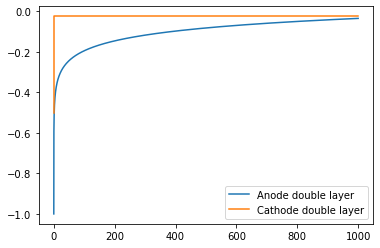

In [25]:
from matplotlib import pyplot as plt
for var in solution.y:
    plt.plot(solution.t,var)
    
plt.legend(['Anode double layer','Cathode double layer'])

For now, the battery double layer potentials simply go to those values needed to sustain the current density.

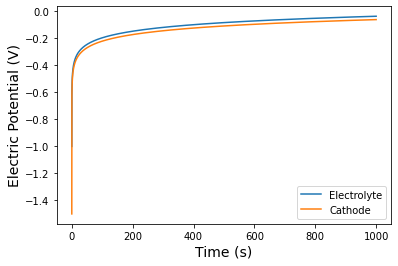

In [29]:
# volatge plot
V_elyte = solution.y[0,:]
V_ca = V_elyte + solution.y[1,:]
plt.plot(solution.t,V_elyte)
plt.plot(solution.t,V_ca)

plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Electric Potential (V)',fontsize=14)
plt.legend(['Electrolyte','Cathode'])
